In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import cv2
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision
from torchvision import datasets, models, transforms, utils
import pandas as pd
import tifffile as tiff
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook as tqdm
import albumentations as aug
from albumentations import (HorizontalFlip,VerticalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise, RandomRotate90, Transpose, RandomBrightnessContrast, RandomCrop)
from albumentations.pytorch import ToTensor
plt.ion()   # interactive mode
import segmentation_models_pytorch as smp

seed = 23
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
import ttach as tta

In [2]:
WEIGHT_PATH = "models/efficientnet-b5_FPN_BCE+DICE_Over9000.pth"
MODEL = 'FPN'
ENCODER = 'efficientnet-b5'

In [3]:
if(MODEL == 'Unet'):
    model = smp.Unet(ENCODER, encoder_weights='imagenet', classes=5, activation=None)
elif(MODEL == 'FPN'):
    model = smp.FPN(ENCODER, encoder_weights='imagenet', classes=5, activation=None)

In [4]:
state = torch.load(WEIGHT_PATH, map_location=lambda storage, loc: storage)
model.load_state_dict(state['state_dict'])
print("Loaded model with dice: ", state['best_dice'])

Loaded model with dice:  0.56686157


In [5]:
class EndoDataset(Dataset):
    def __init__(self, phase, shape = 512, train_size = 474, val_size = 99):
        self.transforms = get_transforms(phase)
        self.phase = phase
        self.shape = shape
        self.train_size = train_size
        self.val_size = val_size
        self.holdout_img_path = os.listdir("./EndoCV/EAD2020-Phase-II_HOLDOUT/SemanticSegmentation/all_frames/")

    def __getitem__(self, idx):
        if self.phase == 'train':
            mask = tiff.imread('./EndoCV/ead2020_semantic_segmentation_TRAIN/masks_ead2020/EAD2020_semantic_'+"{:05d}".format(idx)+'.tif')
            img = cv2.imread('./EndoCV/ead2020_semantic_segmentation_TRAIN/images_ead2020/EAD2020_semantic_'+"{:05d}".format(idx)+'.jpg')
        elif self.phase == 'val':
            mask = tiff.imread('./EndoCV/EAD2020-Phase-II-Segmentation-VALIDATION/semanticMasks/EAD2020_MP1'+"{:04d}".format(idx)+'_mask.tif')
            img = cv2.imread('./EndoCV/EAD2020-Phase-II-Segmentation-VALIDATION/originalImages/EAD2020_MP1'+"{:04d}".format(idx)+'.jpg')
        else:
            img = cv2.imread("./EndoCV/EAD2020-Phase-II_HOLDOUT/SemanticSegmentation/all_frames/"+self.holdout_img_path[idx])#tiff.imread('./EndoCV/EAD2020-Phase-II-Segmentation-VALIDATION/semanticMasks/EAD2020_MP1'+"{:04d}".format(idx)+'_mask.tif')
            mask = tiff.imread("./EndoCV/EAD2020-Phase-II_HOLDOUT/SemanticSegmentation/all_masks/"+self.holdout_img_path[idx][:-4]+'_mask.tif')#cv2.imread('./EndoCV/EAD2020-Phase-II-Segmentation-VALIDATION/originalImages/EAD2020_MP1'+"{:04d}".format(idx)+'.jpg')
        img = cv2.resize(img, (self.shape,self.shape))
        mask_re = np.zeros((5, self.shape,self.shape))
        for i in range(5):
            mask_re[i] = cv2.resize(mask[i], (self.shape,self.shape),interpolation = cv2.INTER_NEAREST)
        mask = (mask_re.transpose(1,2,0) > 0).astype('int')
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        mask = mask[0].permute(2, 0, 1)
        return img, mask

    def __len__(self):
        if self.phase == 'train':
            return self.train_size
        elif self.phase == 'val':
            return self.val_size
        else:
            return len(self.holdout_img_path)

def get_transforms(phase):
    list_transforms = []
    if phase == "train":
        list_transforms.extend([
     aug.Flip(),
     aug.Cutout(num_holes=4, p=0.5),
     aug.OneOf([
         aug.RandomContrast(),
         aug.RandomGamma(),
         aug.RandomBrightness(),
         ], p=1),

     aug.ShiftScaleRotate(rotate_limit=90),
     aug.OneOf([
            aug.GaussNoise(p=.35),
            ], p=.5),
    ])
    list_transforms.extend(
        [
            Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225], p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

def provider(phase, batch_size=8, num_workers=4):
    '''Returns dataloader for the model training'''
    image_dataset = EndoDataset(phase)       
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=False,   
    )

    return dataloader

In [6]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from sklearn.metrics import fbeta_score, precision_recall_fscore_support
from sklearn.metrics import jaccard_similarity_score as jaccard_score

def f2_metric(y_pred_bin, y_true, threshold = 0.5):
    y_pred_bin = (y_pred_bin>threshold).float().detach().cpu().numpy()
    y_true = y_true.float().detach().cpu().numpy()
    batch_size = y_true.shape[0]
    Apred = ((y_pred_bin > 0).astype(np.uint8)).flatten()
    Btrue = ((y_true > 0).astype(np.uint8)).flatten()
    f2_score = []
    jc_score = []
    for i in range(batch_size):
        f2_score.append(fbeta_score(Btrue, Apred, beta=2, average='binary'))
        jc_score.append(jaccard_score(Btrue, Apred)) 
    return np.mean(f2_score), np.mean(jc_score)

def dice_metric(y_pred_bin, y_true, threshold = 0.5):
    y_pred_bin = (y_pred_bin>threshold).float().detach().cpu().numpy()
    y_true = y_true.float().detach().cpu().numpy()
    batch_size = y_true.shape[0]
    dice = []
    precision = []
    recall = []
    for i in range(batch_size):
        p, r, fb_score, support = precision_recall_fscore_support( ((y_true[i]> 0).astype(np.uint8)).flatten(), ((y_pred_bin[i]> 0).astype(np.uint8)).flatten(), average='binary')
        dice.append(fb_score)
        precision.append(p)
        recall.append(r)
    return np.mean(dice), np.mean(precision), np.mean(recall)

def metric_pos_neg(probability, truth, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    channels = truth.shape[1]
    with torch.no_grad():
        probability = probability.view(batch_size,channels,-1)
        truth = truth.view(batch_size,5,-1)
        assert(probability.shape == truth.shape)
        dice_pos_ = np.zeros(channels)
        dice_neg_ = np.zeros(channels)
        for i in range(channels):
            p = (probability[:,i,:] > threshold).float()
            t = (truth[:,i,:] > 0.5).float()
            t_sum = t.sum(-1)
            p_sum = p.sum(-1)
            neg_index = torch.nonzero(t_sum == 0)
            pos_index = torch.nonzero(t_sum >= 1)
            dice_neg = (p_sum == 0).float()
            dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))
            dice_neg = dice_neg[neg_index]
            dice_pos = dice_pos[pos_index]
            dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
            dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
            dice_neg_[i]=dice_neg
            dice_pos_[i]=dice_pos
        dice_neg = dice_neg_.mean()
        dice_pos = dice_pos_.mean()
    return dice_neg, dice_pos

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []
        self.f2_scores = []
        self.recall = []
        self.precision = []


    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice_neg, dice_pos = metric_pos_neg(probs, targets, self.base_threshold)
        dice, p, r = dice_metric(probs, targets)
        f2, iou = f2_metric(probs, targets)
        self.base_dice_scores.append(dice)
        self.precision.append(p)
        self.recall.append(r)
        self.dice_neg_scores.append(dice_neg)
        self.dice_pos_scores.append(dice_pos)
        self.f2_scores.append(f2)
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.mean(self.base_dice_scores)
        precision = np.mean(self.precision)
        recall = np.mean(self.recall)
        dice_neg = np.mean(self.dice_neg_scores)
        dice_pos = np.mean(self.dice_pos_scores)
        f2 = np.mean(self.f2_scores)
        iou = np.nanmean(self.iou_scores)
        
        return dice, dice_pos, dice_neg, iou, f2, precision, recall

def epoch_log(phase, meter, start):
    '''logging the metrics at the end of an epoch'''
    dice, dice_pos, dice_neg, iou, f2, precision, recall = meter.get_metrics()
    print("IoU: %0.4f | dice: %0.4f | dice_pos: %0.4f | dice_neg: %0.4f | f2_score: %0.4f | precision: %0.4f | recall: %0.4f" % (iou, dice, dice_pos, dice_neg, f2, precision, recall))
    return dice, iou, f2, dice_pos, dice_neg, precision, recall

In [7]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self,model, bs, name = MODEL+"_"+ENCODER):
        self.num_workers = 4
        self.batch_size = {"train": bs, "val": bs, "ho": bs}
        self.phases = ["train", "val", "ho"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.net = self.net.to(self.device)
        self.name = name
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                phase=phase,
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.F2_scores = {phase: [] for phase in self.phases}
        
    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs = self.net(images)
        return outputs

    def iterate(self, phase):
        meter = Meter(phase)
        start = time.strftime("%H:%M:%S")
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
        tk0 = tqdm(dataloader, total=total_batches)
        for itr, batch in enumerate(tk0):
            # replace `dataloader` with `tk0` for tqdm
            images, targets = batch
            outputs = self.forward(images, targets)
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)           
        dice, iou, f2, dice_pos, dice_neg, precision, recall = epoch_log(phase, meter, start)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)
        self.F2_scores[phase].append(f2)
        torch.cuda.empty_cache()
        return dice

    def train_end(self):
        train_dice = self.dice_scores["train"][0]
        train_iou = self.iou_scores["train"][0]
        train_f2 = self.F2_scores["train"][0]
        
        val_dice = self.dice_scores["val"][0]
        val_iou = self.iou_scores["val"][0]
        val_f2 = self.F2_scores["val"][0]
        
        ho_dice = self.dice_scores["ho"][0]
        ho_iou = self.iou_scores["ho"][0]
        ho_f2 = self.F2_scores["ho"][0]
#         print(val_dice,val_iou,val_f2)
        df_data=np.array([train_dice,train_iou,train_f2,val_dice,val_iou,val_f2,ho_dice,ho_iou,ho_f2],ndmin=2,)
#         print(df_data.shape)
        df = pd.DataFrame(df_data,columns = ["train_dice","train_iou","train_f2","val_dice","val_iou","val_f2","ho_dice","ho_iou","ho_f2"])
        df.to_csv(self.name+'.csv')

    def start(self):
        self.iterate("train")
        self.net.eval()
        with torch.no_grad():
            self.iterate("val")
            self.iterate("ho")
        print()
        self.train_end()

In [8]:
Trainer(model, 1).start()


IoU: 0.9843 | dice: 0.5752 | dice_pos: 0.2043 | dice_neg: 0.2759 | f2_score: 0.5603 | precision: 0.7111 | recall: 0.5759



IoU: 0.9542 | dice: 0.4326 | dice_pos: 0.1795 | dice_neg: 0.3677 | f2_score: 0.4150 | precision: 0.6196 | recall: 0.4137



IoU: 0.9869 | dice: 0.6020 | dice_pos: 0.2647 | dice_neg: 0.3371 | f2_score: 0.5647 | precision: 0.7095 | recall: 0.5448



In [9]:
model.to(torch.device("cuda:0"))
def visuaalize(phase = 'train',thresh = 0.5):
    global model
    dataloader = provider(phase, batch_size=1, num_workers=4)
    for idx,(img,mask) in enumerate(dataloader):
        model.eval()
#         model = tta.SegmentationTTAWrapper(model, tta.Compose([tta.HorizontalFlip(),]), merge_mode='mean')
        output_mask = model(img.to(torch.device("cuda:0"))).sigmoid().detach().cpu().numpy()>thresh
        fig=plt.figure(figsize=(50, 20), dpi= 80, facecolor='w', edgecolor='k')
        std = np.array([0.229,0.224,0.225])
        mean = np.array([0.485,0.456,0.406])
        plt.subplot(1, 7, 1)
        img = ((img[0].numpy().transpose((1,2,0))*std+mean)*255).astype(np.uint8)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        for i in range(2,7):
            plt.subplot(1, 7, i)
            plt.imshow(mask[0,i-2,...])
        fig.show()
        fig=plt.figure(figsize=(50, 20), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(1, 7, 1)
        plt.imshow(img)
        for i in range(2,7):
            plt.subplot(1, 7, i)
            plt.imshow(output_mask[0,i-2,...])
        fig.show()
        plt.show()
        if (idx+1)%10 == 0:
            break
        torch.cuda.empty_cache()

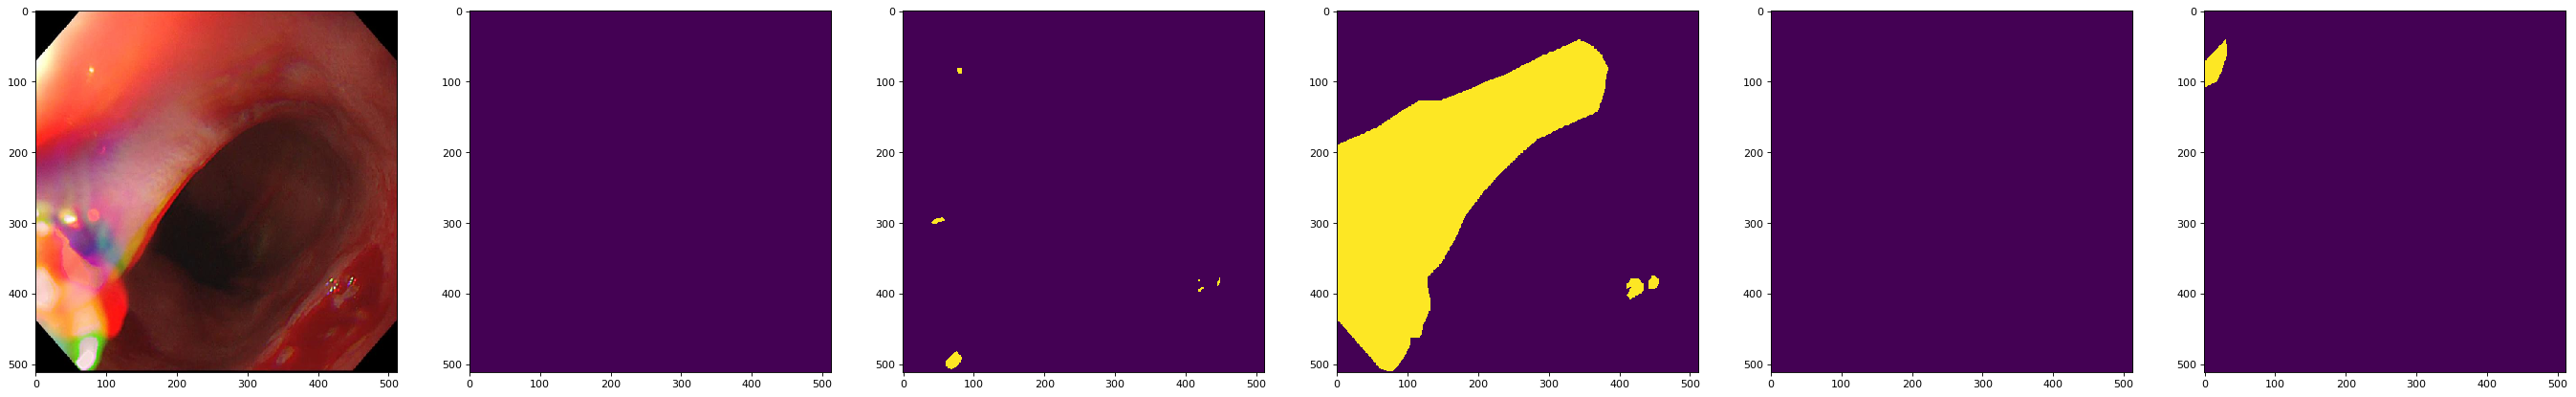

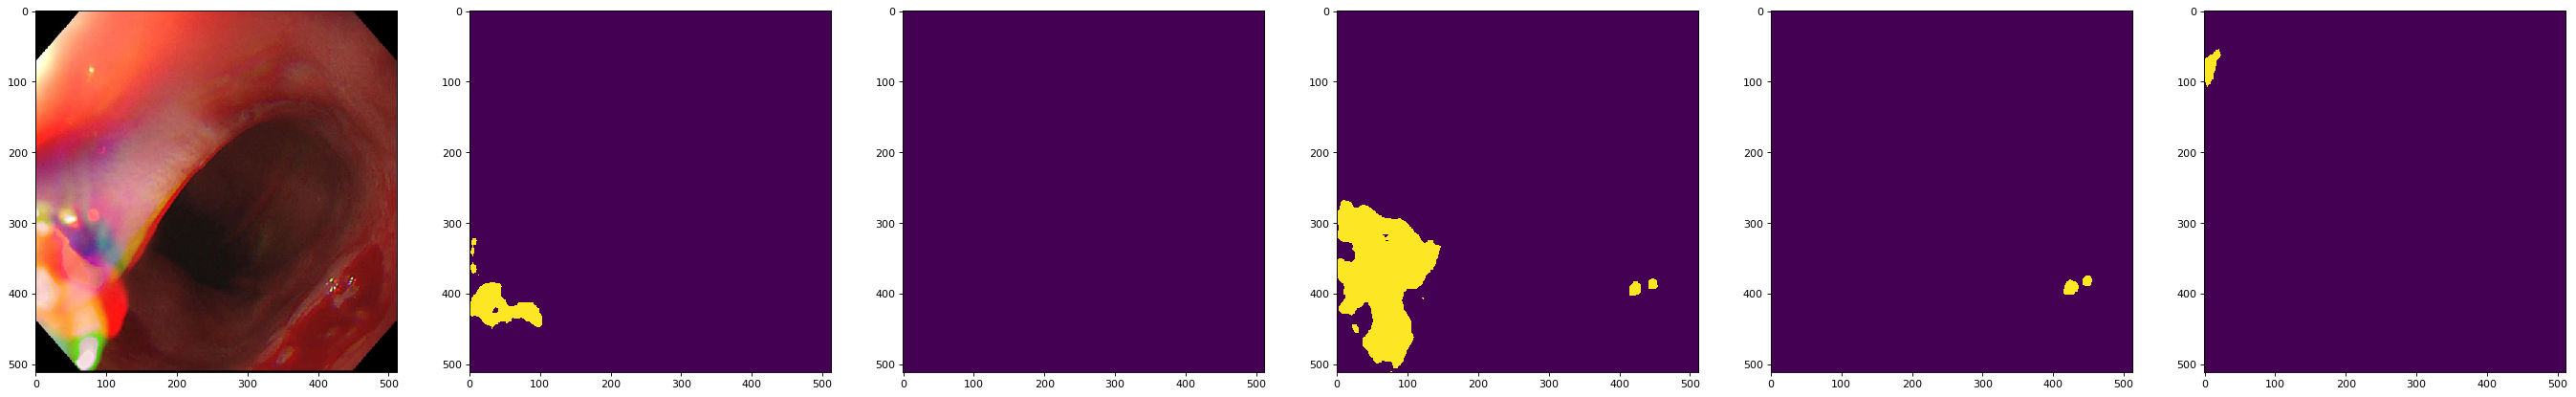

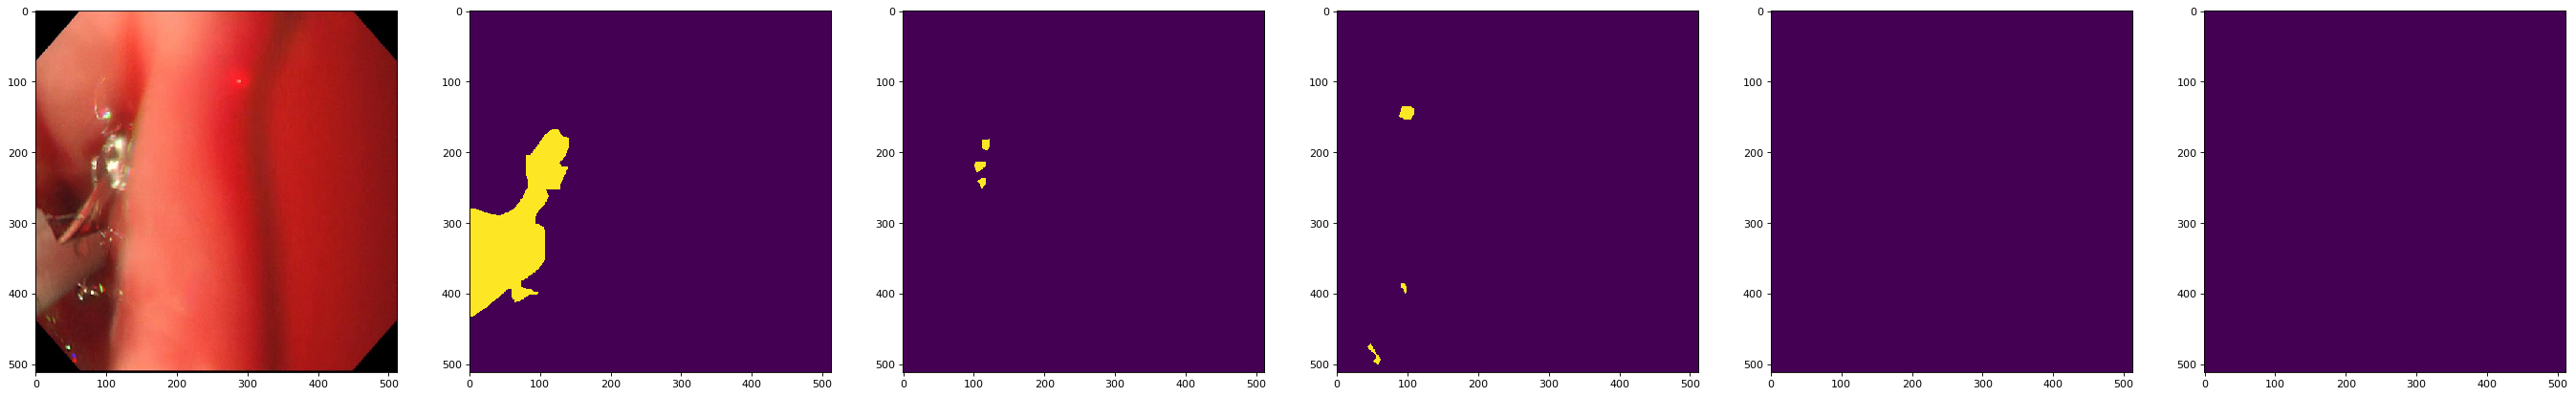

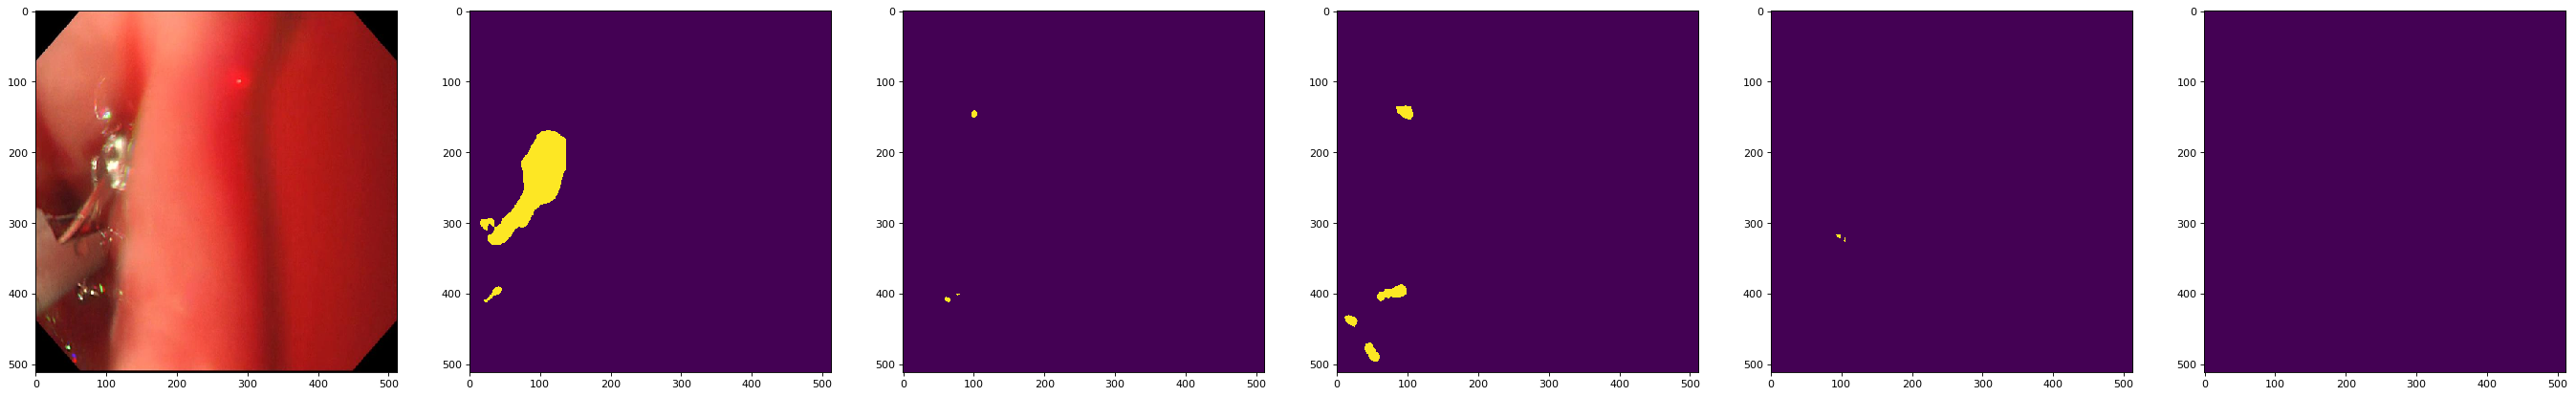

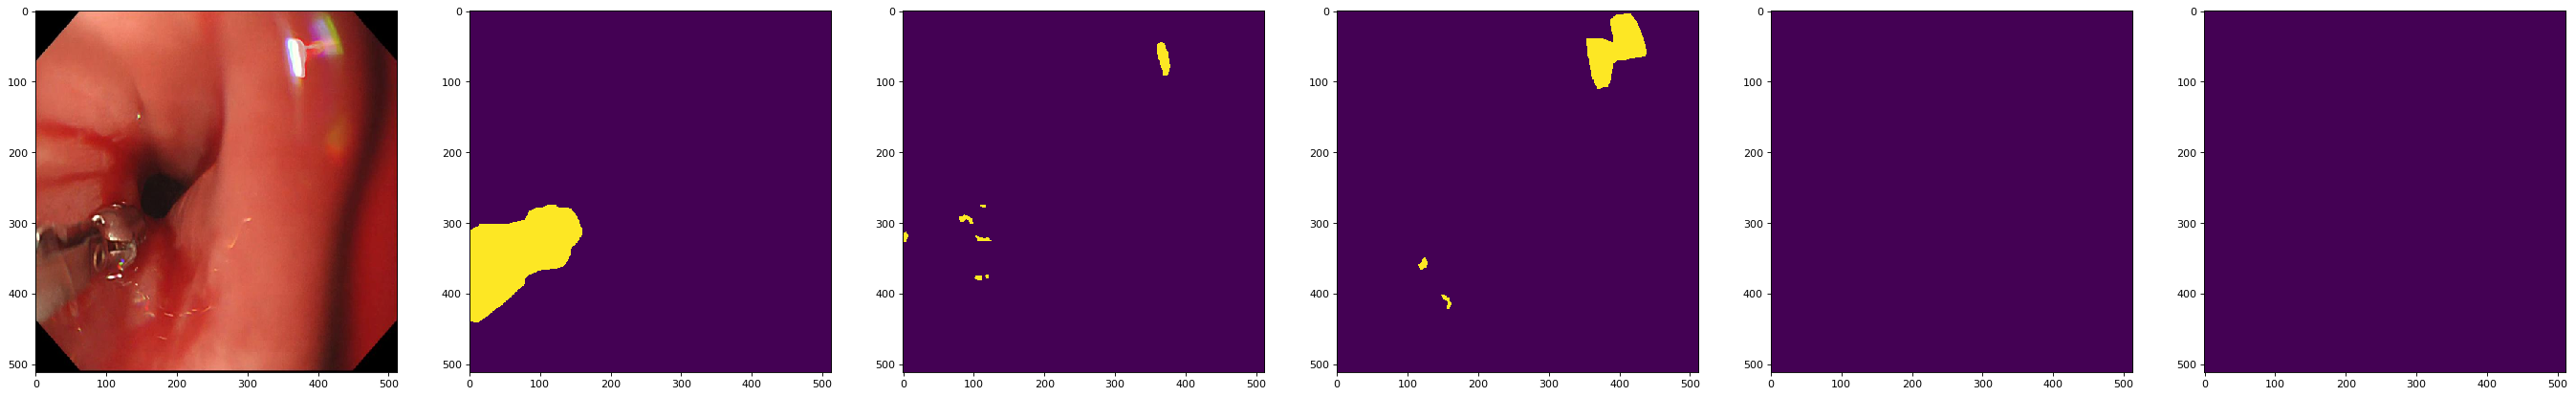

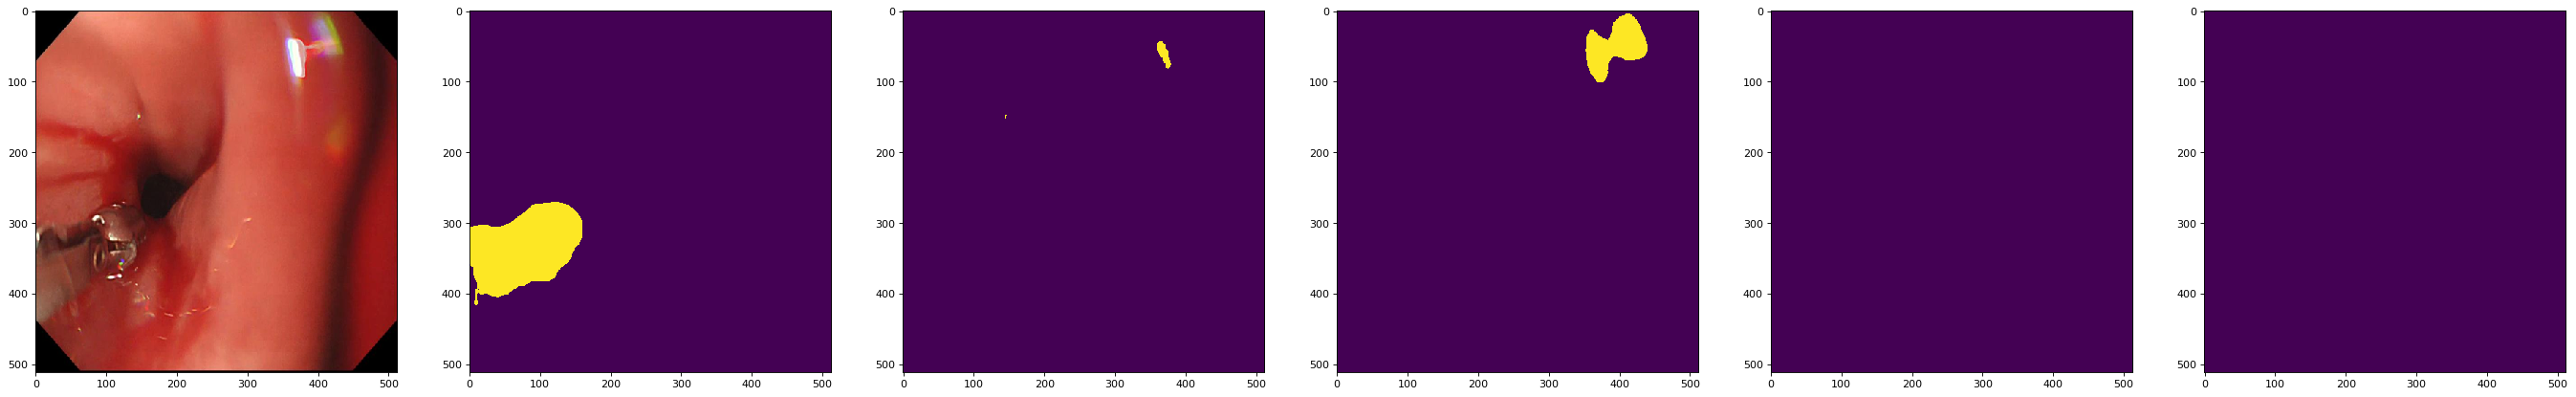

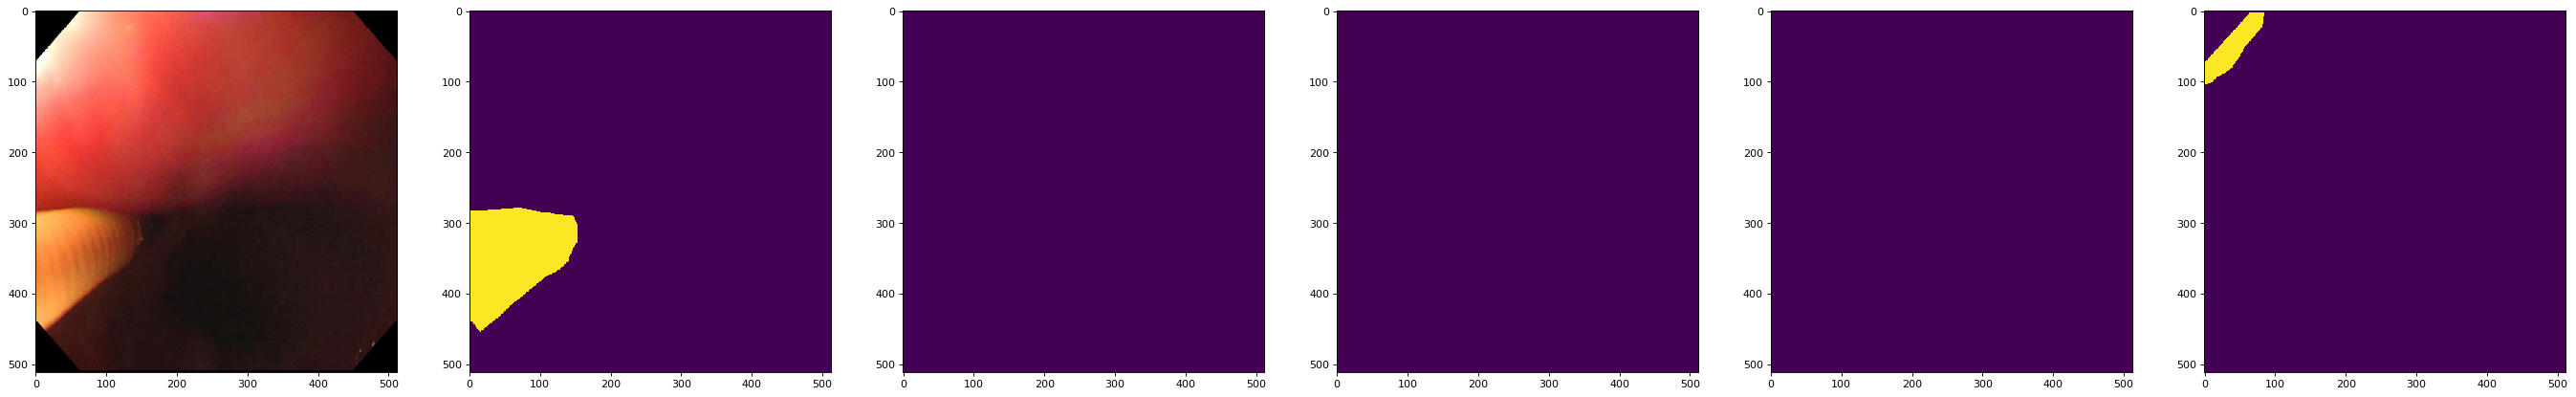

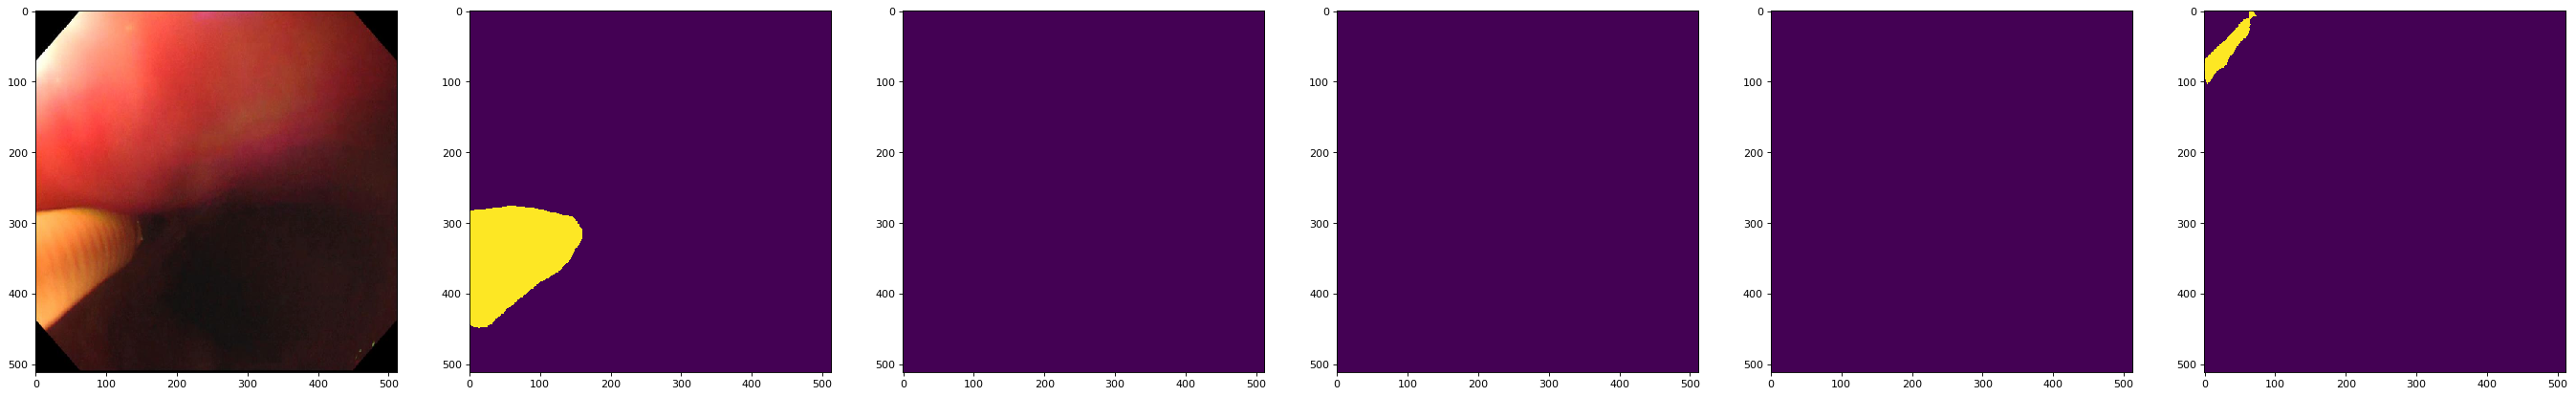

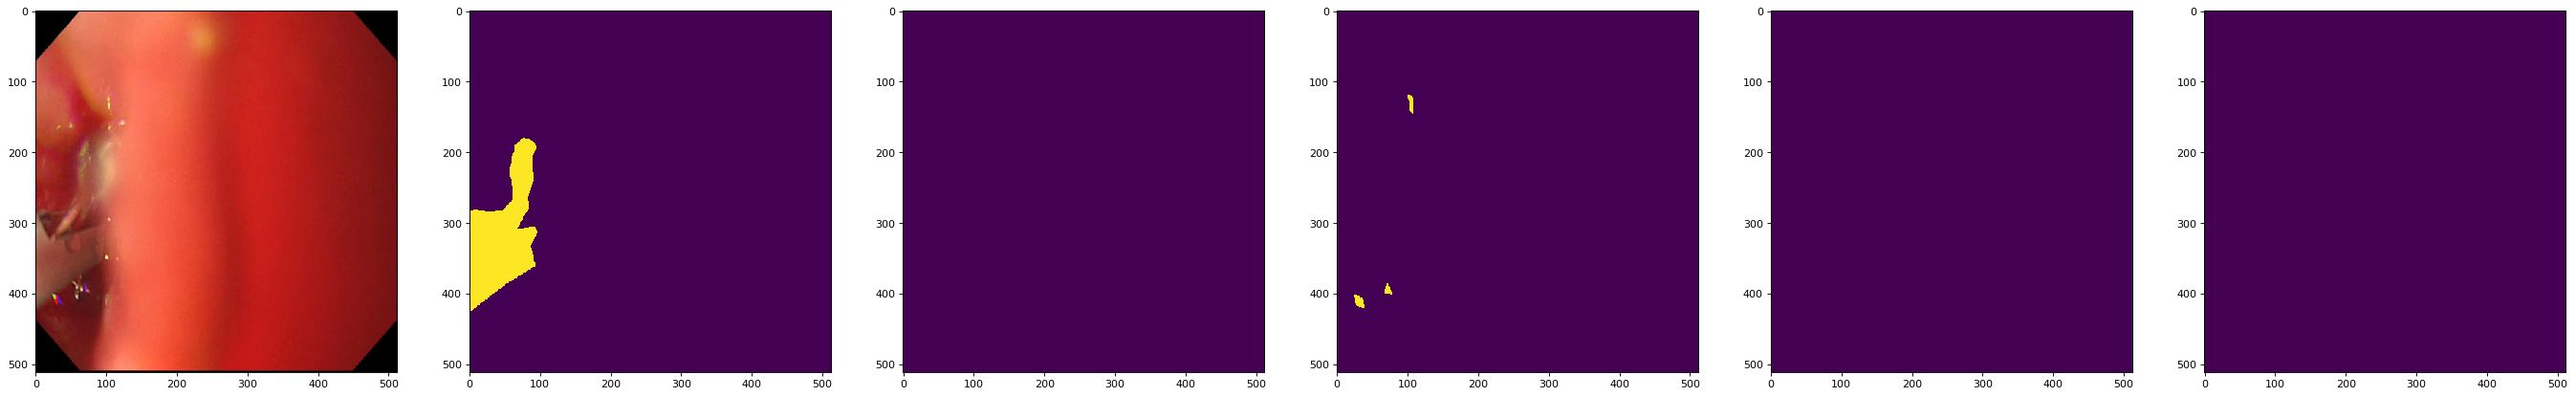

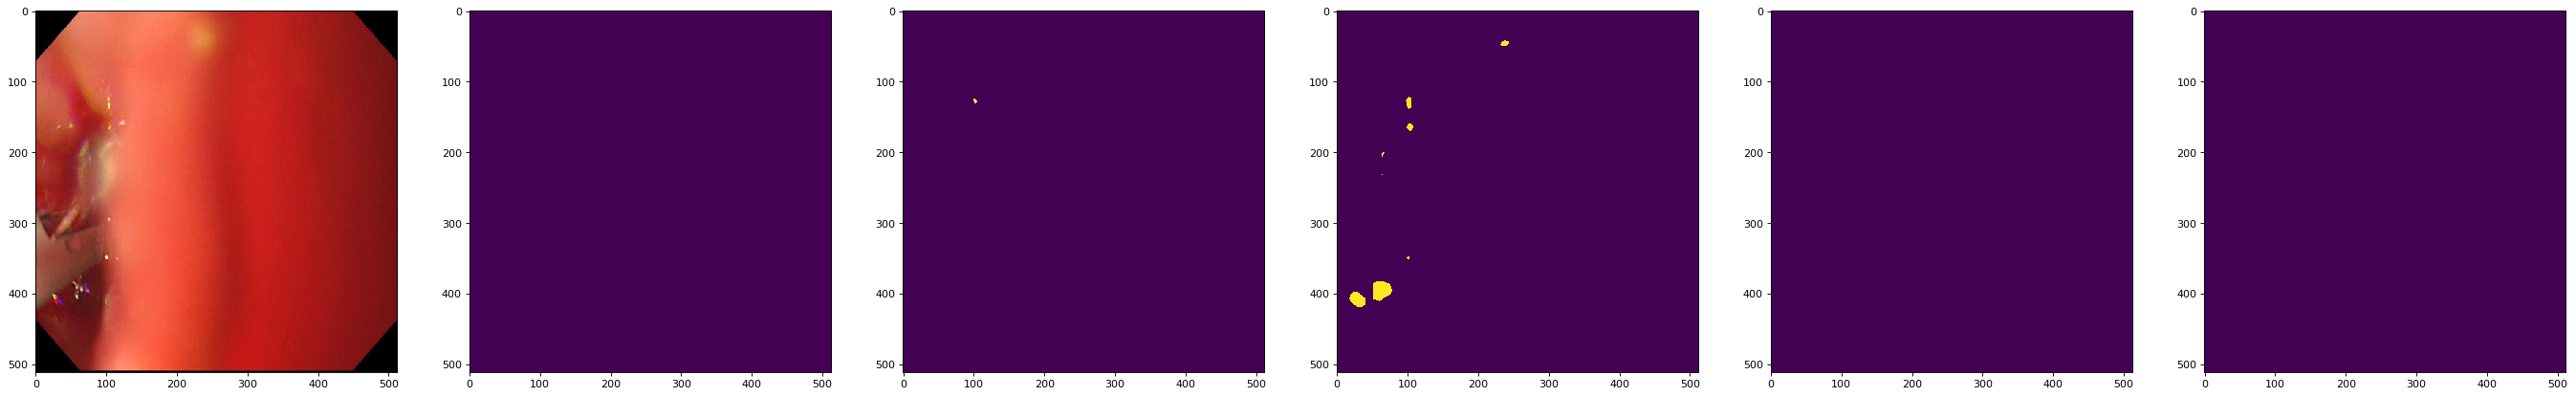

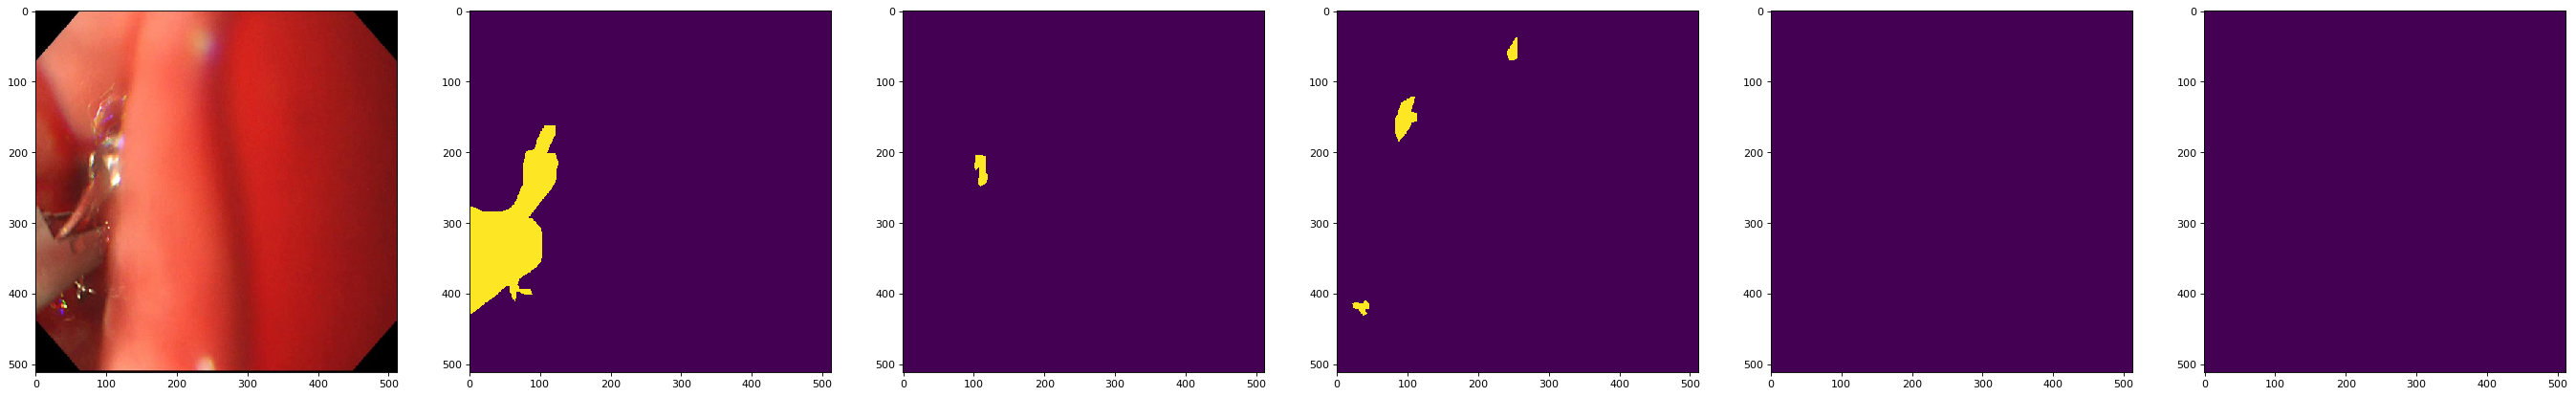

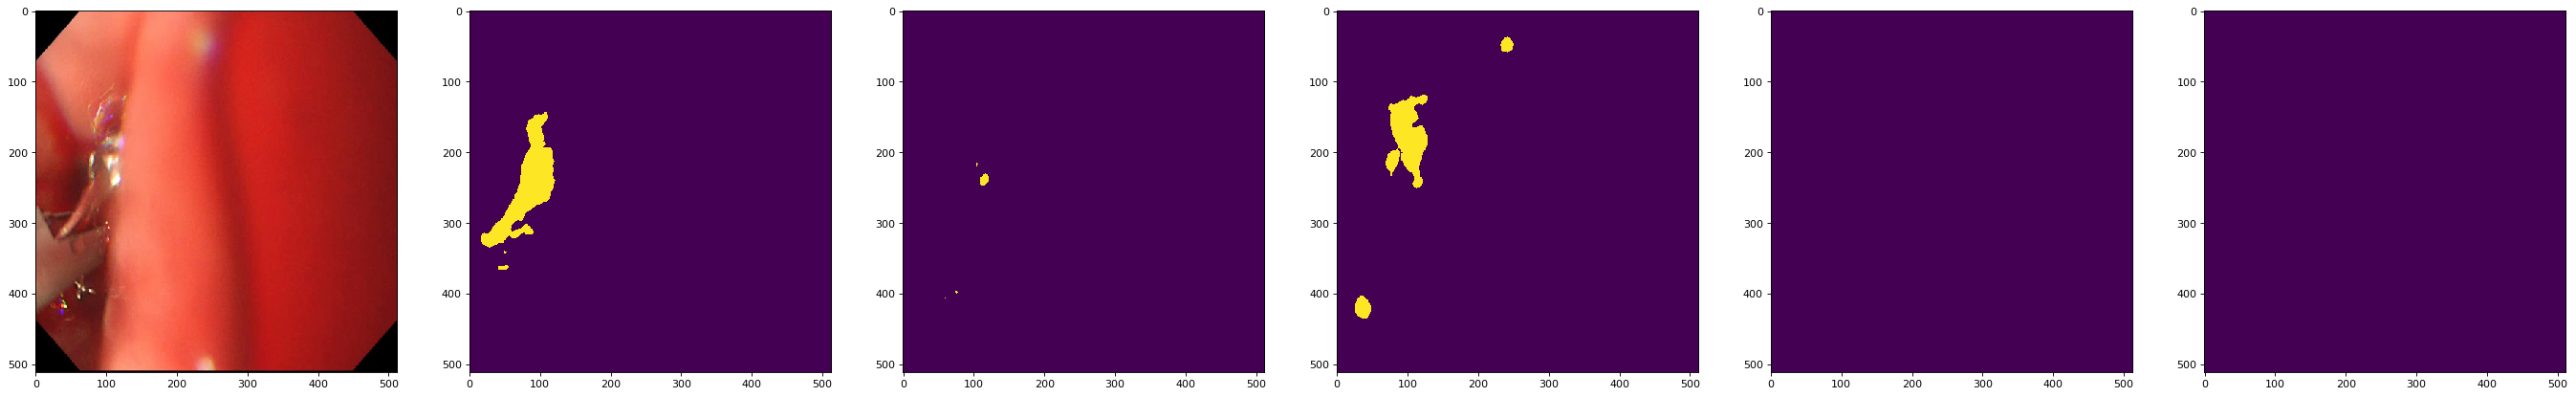

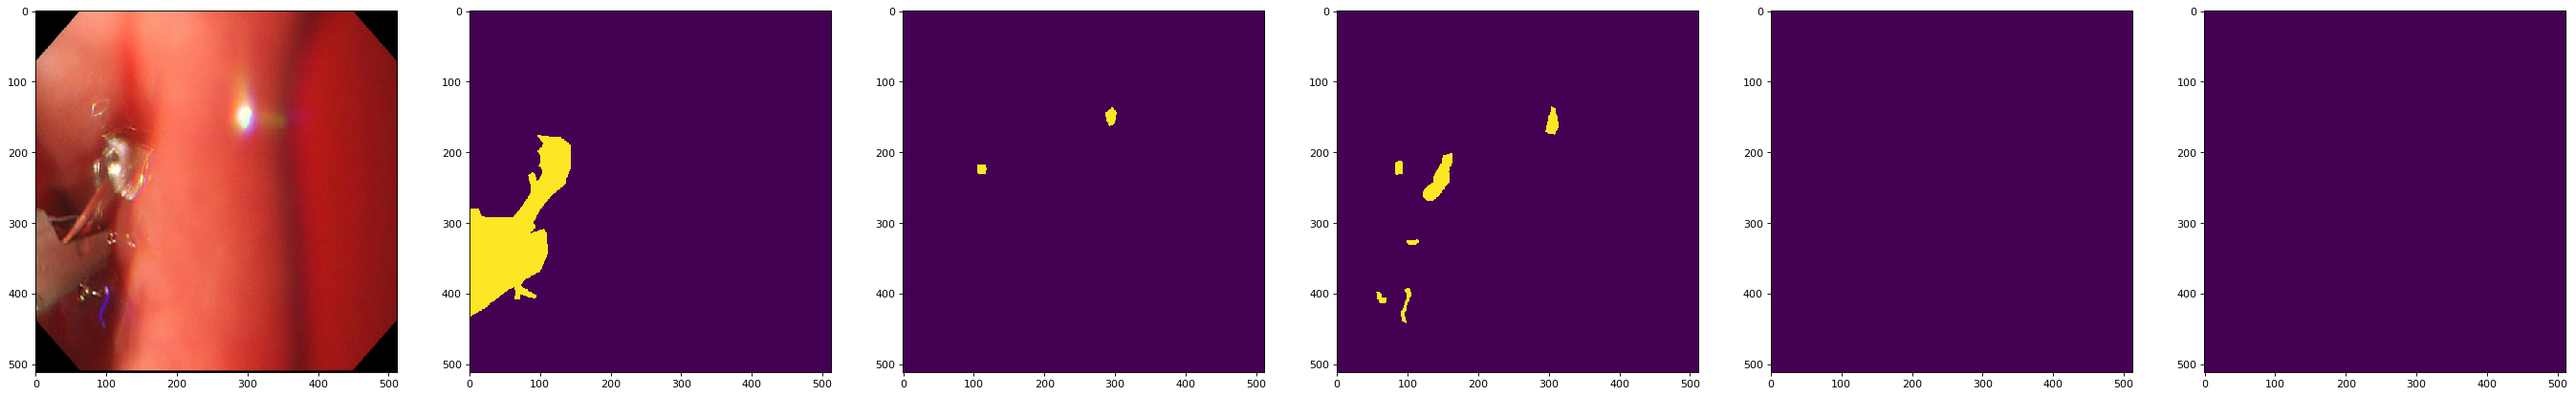

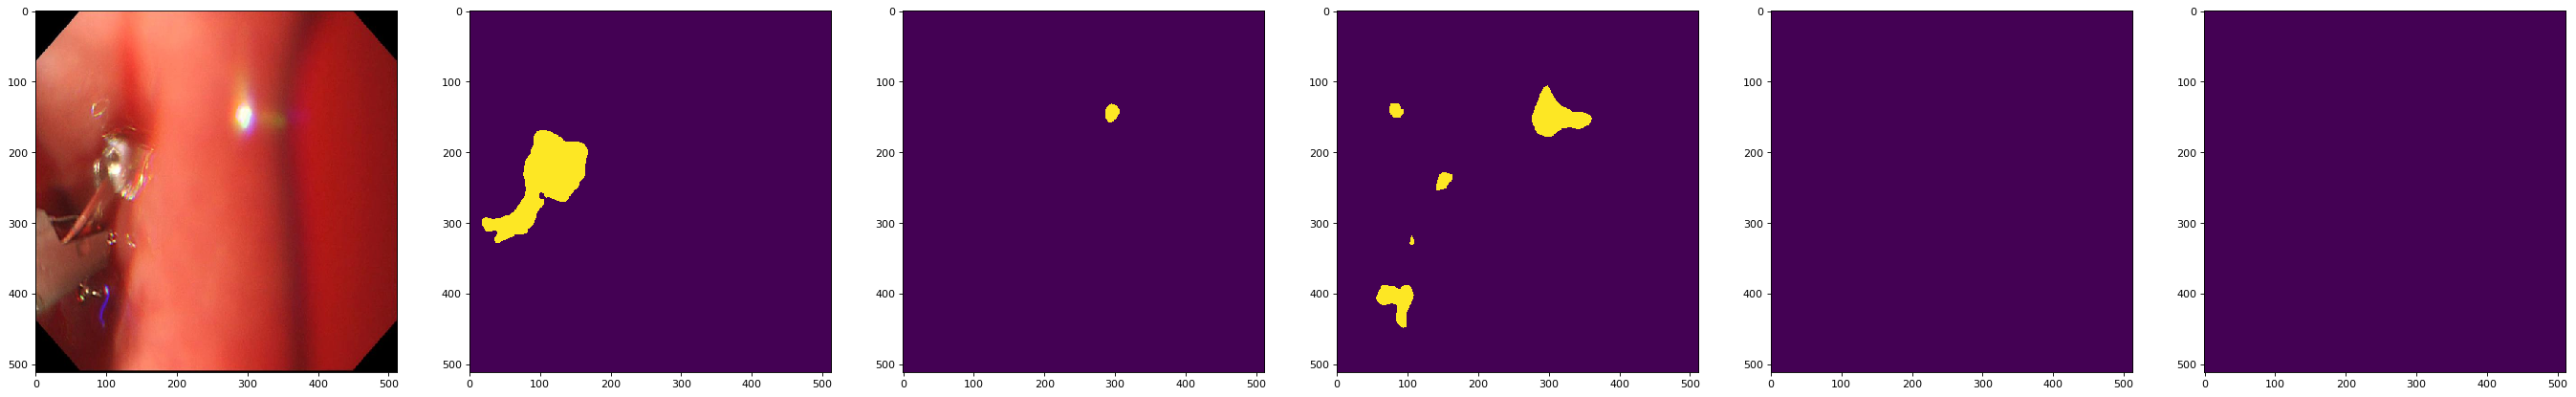

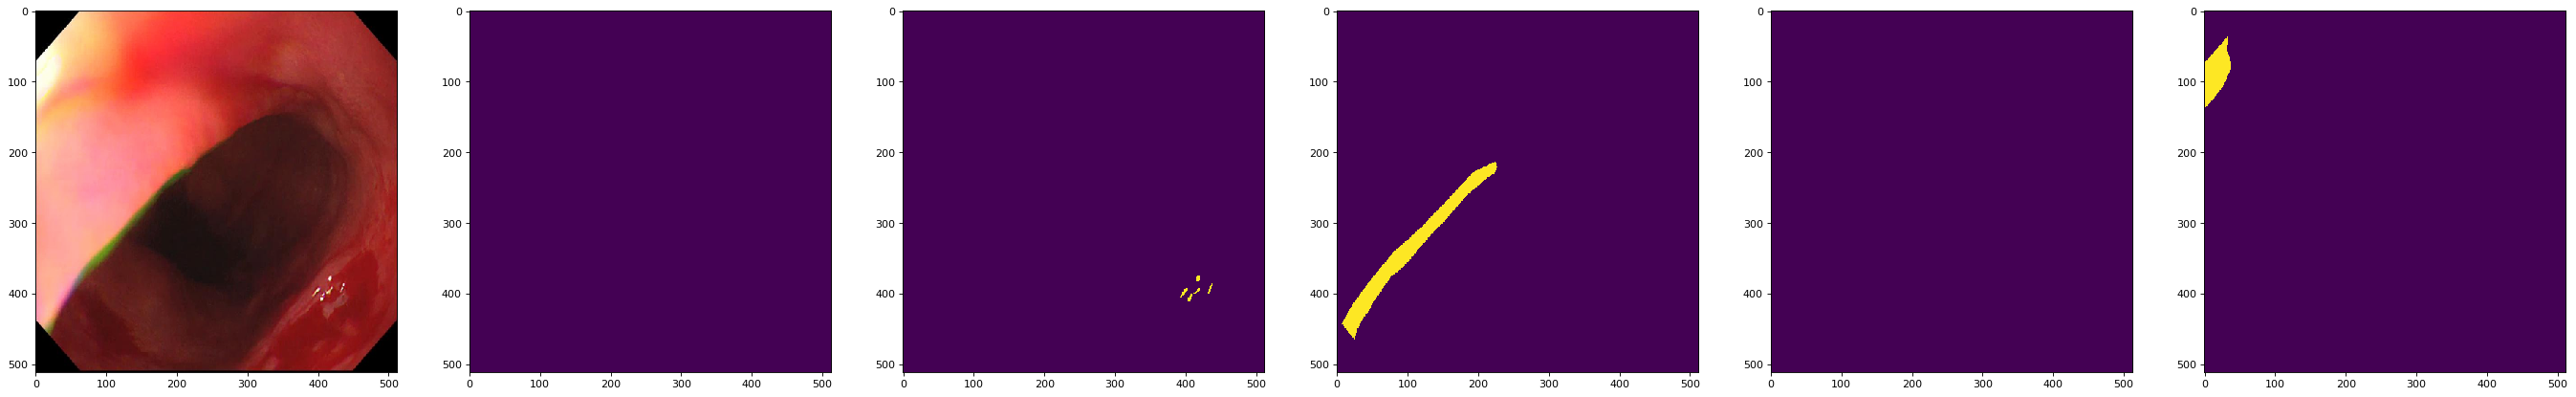

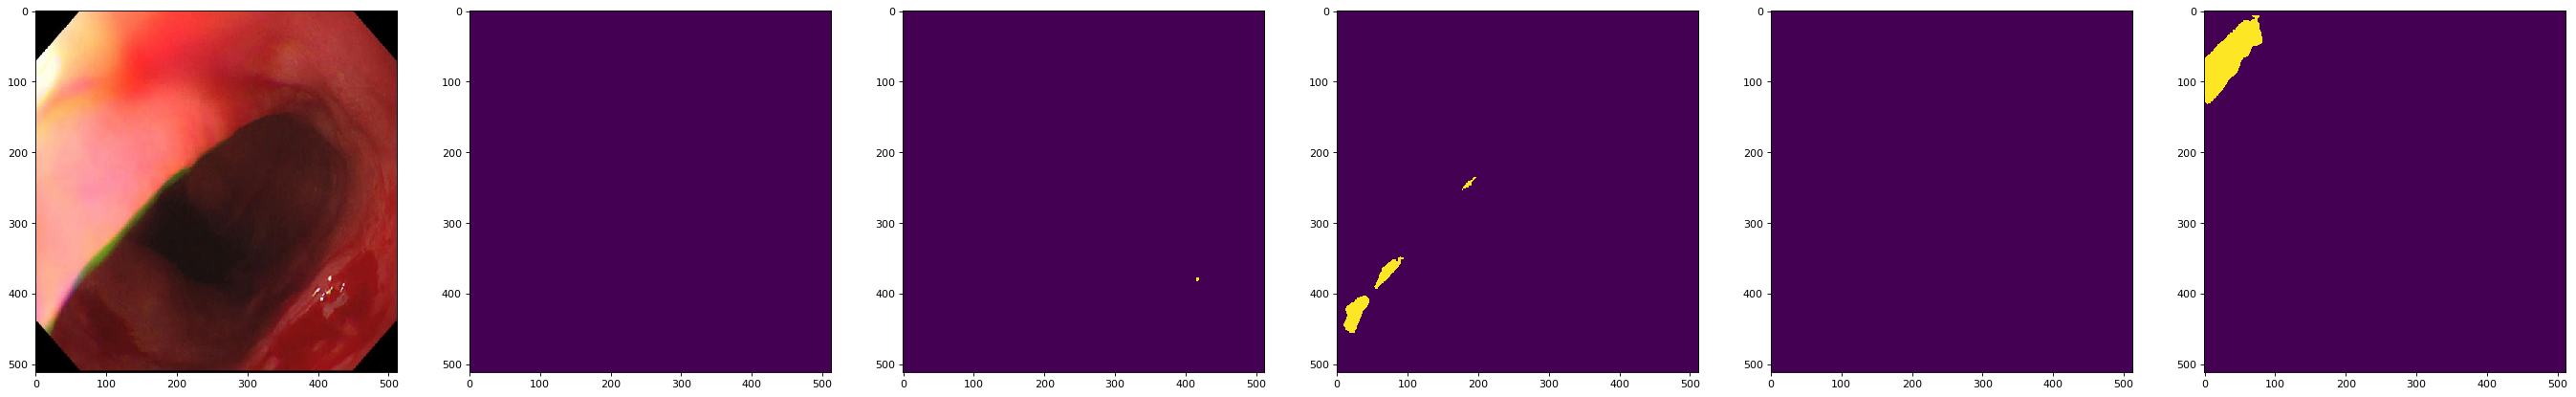

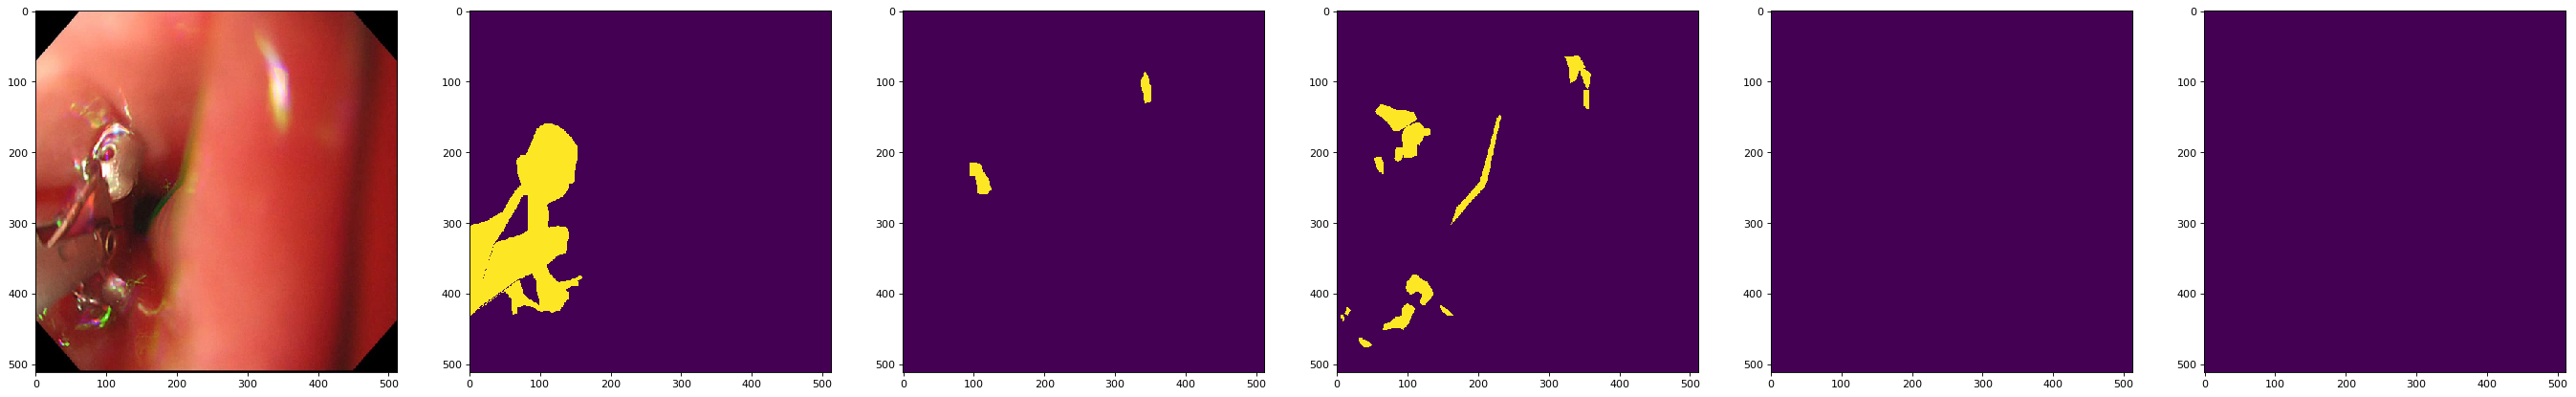

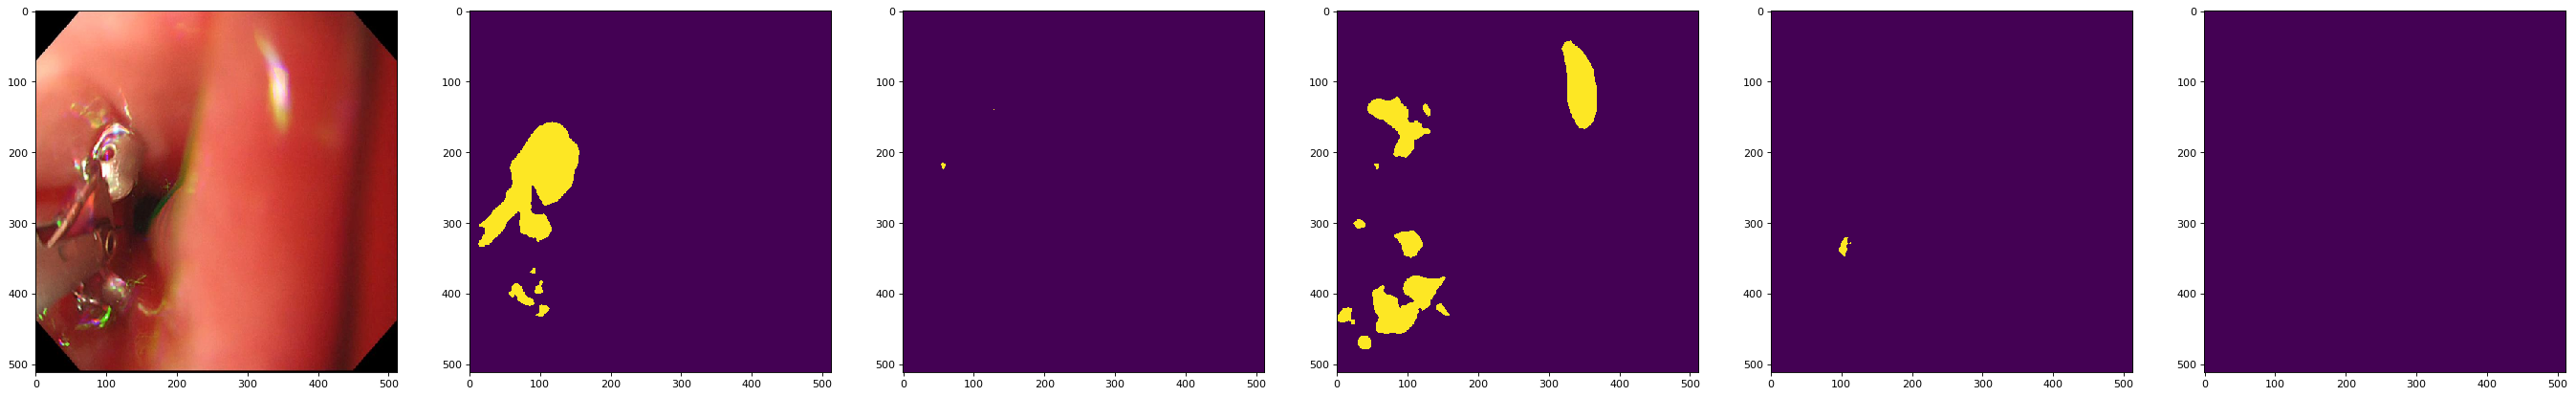

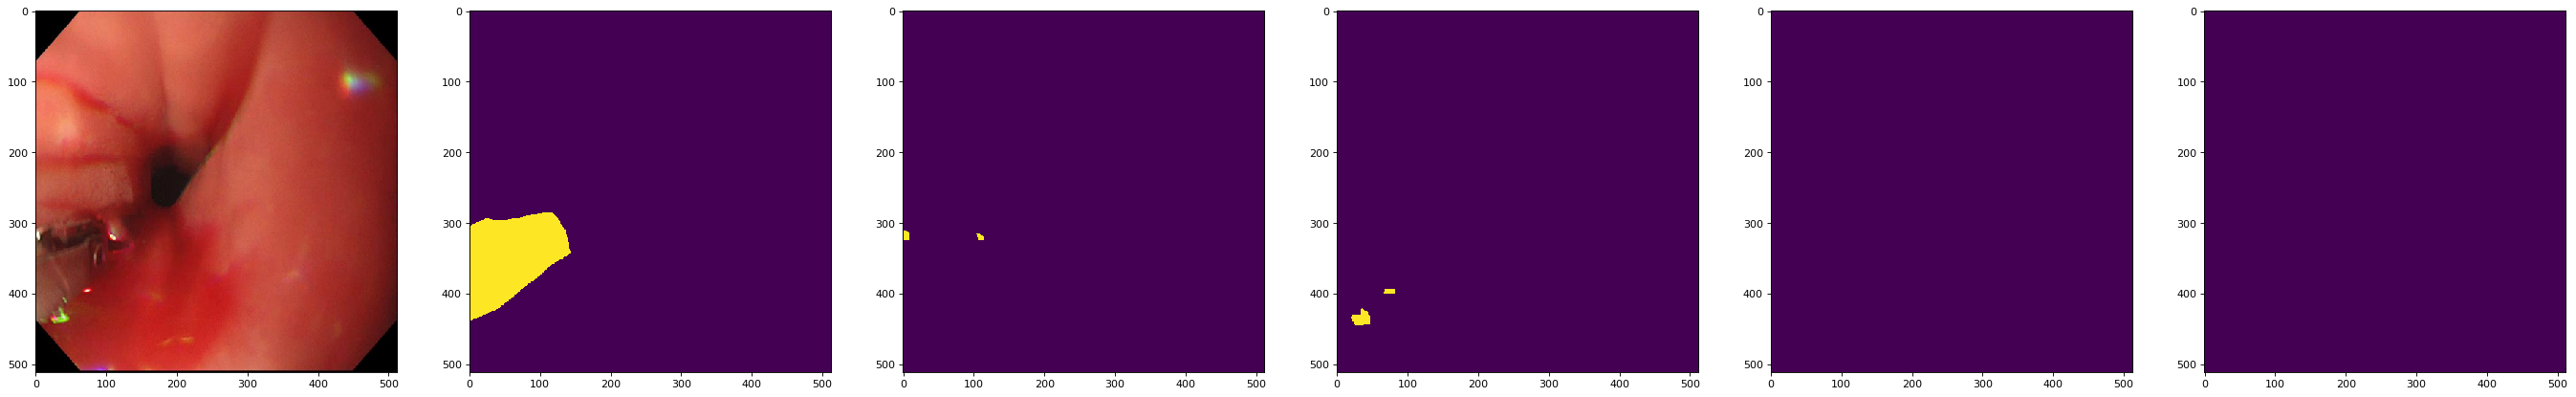

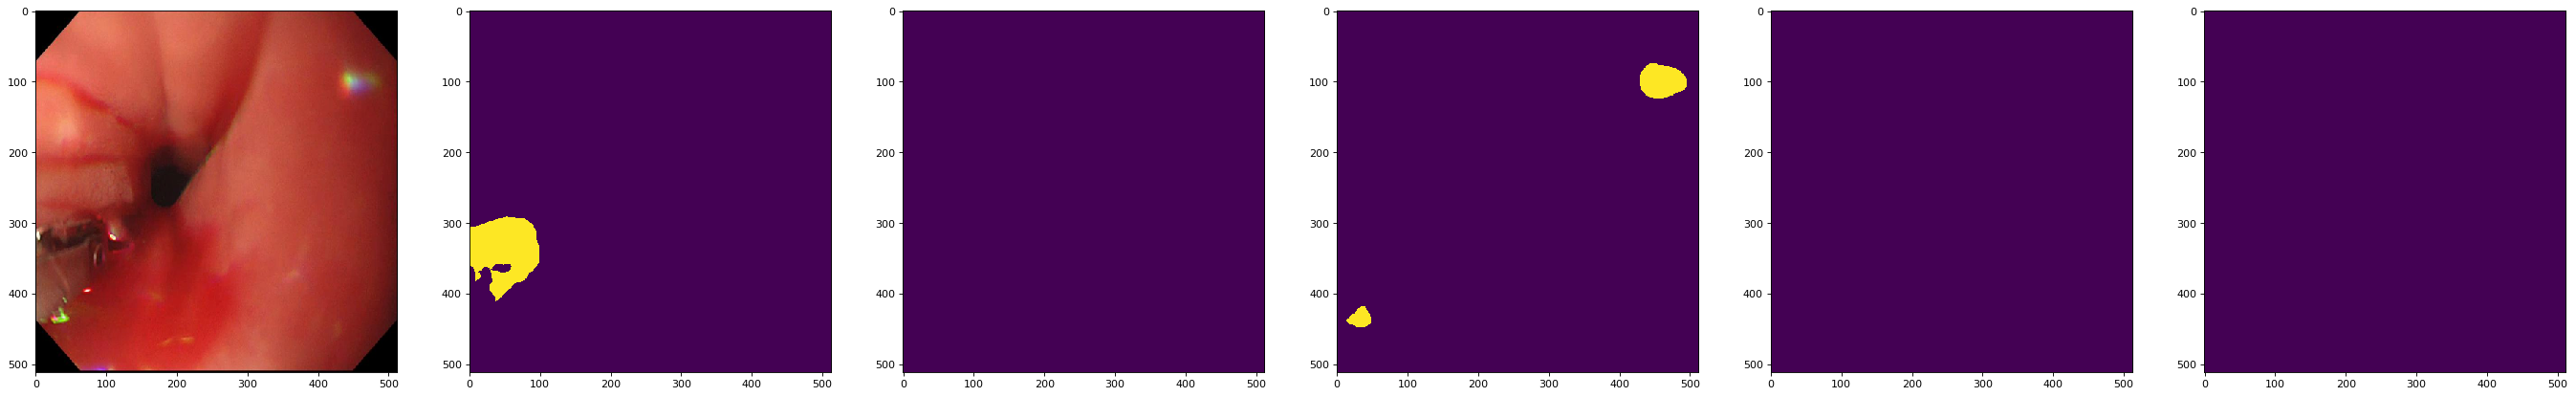

In [10]:
visuaalize(provider('ho',1),0.5)